In [1]:
from block_methods import *
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm
import matplotlib.colors as colors
from scipy import integrate

%load_ext autoreload
%autoreload 2

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
n = 1000 # matrix dimension
b = [1, 2, 3, 4, 8, 16] # block size
step = 5
thresh = 1e-8

# set up matrix
Λ = np.linspace(1e-2,1,n)
H = np.diag(Λ)

λmin = np.min(Λ)
λmax = np.max(Λ)

f = lambda x: np.sqrt(x)

K = 10 # max iter
w = λmin/100

nr = 100
ni = 50

zrs = np.linspace(-1,2,nr)
zis = np.linspace(0,1.5,ni)
np.random.seed(0)

In [4]:
ratio_syms = []
zis_syms = []

Evals = []

ERTs = np.zeros(len(b))
for k in np.arange(len(b)):
    V = np.random.randn(n,b[k])

    Q,Qkp1,A,B,B_0 = block_lanczos(H, V, K, K+1)
    T = get_block_tridiag(A,B)
    Eval,Evec = np.linalg.eigh(T)
    
    Evals.append(Eval)
    
    orthTest(Q, b[k], K, thresh)
    threeTermTest(H, Q, T, Qkp1, B, b[k], K, thresh)
    
    ratio = np.full((nr,ni),np.nan)
    fzs = np.full((nr,ni),np.nan)

    ERT = np.full(nr*ni, 0, dtype = float)

    for i,zr in enumerate(zrs):
        for j,zi in enumerate(zis):

            z = zr + 1j*zi

            CwinvCz = get_CwinvCz(Eval,Evec,z,w,b[k],B_0)

            errz = 1/(Λ-z)[:,None]*V - Q@(Evec@np.diag(1/(Eval-z))@Evec.T@Ei(b[k]*K,b[k],1)@B_0)
            errw = 1/(Λ-w)[:,None]*V - Q@(Evec@np.diag(1/(Eval-w))@Evec.T@Ei(b[k]*K,b[k],1)@B_0)

            ratio[i,j] = H_wz(w,z,λmin,λmax)*np.linalg.norm(CwinvCz,ord=2)*h_norm(errw, Λ, h_w, w)/h_norm(errz, Λ, h_w, w)

            fzs[i,j] = np.abs(f(z))
            
    ERTs[k] = np.mean(ERT)
            
    ratio_sym = np.vstack([ratio.T[::-1],ratio.T])
    zis_sym = np.hstack([zis[::-1],-zis])
            
    ratio_syms.append(ratio_sym)
    zis_syms.append(zis_sym)

/src/notebooks/block_lanczos_CIF/block_methods/block_methods.py:218: RuntimeWarning: divide by zero encountered in cdouble_scalars
  return np.abs((z-w)/np.imag(z))
/src/notebooks/block_lanczos_CIF/block_methods/block_methods.py:218: RuntimeWarning: invalid value encountered in cdouble_scalars
  return np.abs((z-w)/np.imag(z))
/tmp/ipykernel_289/2108828521.py:31: RuntimeWarning: divide by zero encountered in true_divide
  errz = 1/(Λ-z)[:,None]*V - Q@(Evec@np.diag(1/(Eval-z))@Evec.T@Ei(b[k]*K,b[k],1)@B_0)
/tmp/ipykernel_289/2108828521.py:31: RuntimeWarning: invalid value encountered in true_divide
  errz = 1/(Λ-z)[:,None]*V - Q@(Evec@np.diag(1/(Eval-z))@Evec.T@Ei(b[k]*K,b[k],1)@B_0)
/tmp/ipykernel_289/2108828521.py:31: RuntimeWarning: invalid value encountered in multiply
  errz = 1/(Λ-z)[:,None]*V - Q@(Evec@np.diag(1/(Eval-z))@Evec.T@Ei(b[k]*K,b[k],1)@B_0)


In [5]:
np.save("data/figure_3.2/ratio_syms", ratio_syms)
np.save("data/figure_3.2/zis_syms", zis_syms)

In [6]:
ratio_syms = np.load("data/figure_3.2/ratio_syms.npy")
zis_syms = np.load("data/figure_3.2/zis_syms.npy")

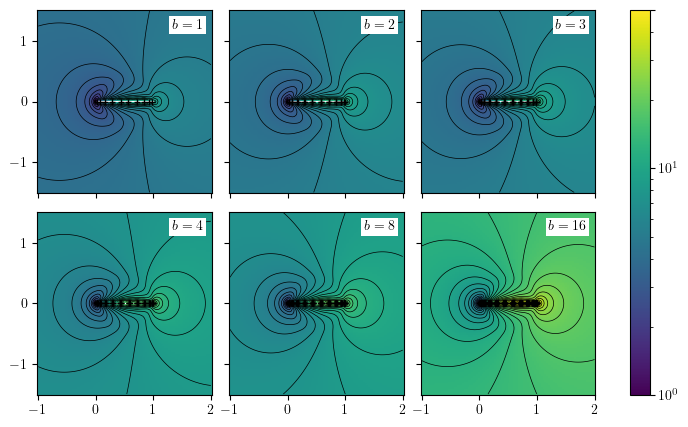

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(9,5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.1, hspace=.1)

for i in np.arange(len(b)):
    axes[i // 3, i % 3].text(.95,.95,f'$b = {b[i]}$',ha='right', va='top', transform=axes[i // 3, i % 3].transAxes,bbox=dict(facecolor='white',edgecolor='none',pad=2))

    axes[i // 3, i % 3].plot(Evals[i],np.zeros_like(Evals[i]),ls='None',marker='+',ms=5,lw=.5,color='k')
    
    im = axes[i // 3, i % 3].pcolor(zrs,zis_syms[i],ratio_syms[i],norm=colors.LogNorm(vmin=1e0,vmax=5e1),rasterized=True)
    axes[i // 3, i % 3].contour(zrs,zis_syms[i],ratio_syms[i],colors='k',linewidths=.5,levels=10**np.linspace(0,2,40))
    
fig.colorbar(im, ax=axes.ravel().tolist(), ticks = [1,1e1,5e1])

plt.savefig("imgs/figure_3.2.pdf")